# WEEK 4. Visualization and Interpretability

## Ungraded Lab 2: Cats vs. Dogs Class Activation Maps

You will again practice with CAMs in this lab and this time there will only be two classes: Cats and Dogs. You will be revisiting this exercise in this week's programming assignment so it's best if you become familiar with the steps discussed here, particularly in preprocessing the image and building the model.

### Contents - YC 2025.06.06 Fri
0. Imports
1. Download and Prepare the Dataset
2. Build the classifier (Train here!!!)
3. Building the CAM model - `two outputs`
4. Generating CAM map (`superimpose` CAM on original image) ****


In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

## 1. Download and Prepare the Dataset

We will use the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset and we can load it via Tensorflow Datasets. The images are labeled 0 for cats and 1 for dogs.

In [2]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

The cell below will preprocess the images and create batches before feeding it to our model.

In [3]:
def augment_images(image, label):

  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)

## 2. Build the classifier (Train here!!!)

This will look familiar to you because it is almost identical to the previous model we built. The key difference is the output is just one unit that is sigmoid activated. This is because we're only dealing with two classes.

In [4]:
model = Sequential()

model.add(keras.Input(shape=(300,300,3)))
model.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 300, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,569 (381.13 KB)

 Trainable params: 97,569 (381.13 KB)

 Non-trainable params: 0 (0.00 B)

The loss can be adjusted from last time to deal with just two classes. For that, we pick `binary_crossentropy`.

In [5]:
# Training will take around 30 minutes to complete using a GPU. Time for a break!

model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))
model.fit(train_batches,epochs=2)

Epoch 1/2


2025-06-06 09:54:36.678932: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


163/582 ━━━━━━━━━━━━━━━━━━━━ 2:21 338ms/step - accuracy: 0.5171 - loss: 0.6958

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


195/582 ━━━━━━━━━━━━━━━━━━━━ 2:10 338ms/step - accuracy: 0.5209 - loss: 0.6945

206/582 ━━━━━━━━━━━━━━━━━━━━ 2:07 338ms/step - accuracy: 0.5222 - loss: 0.6940

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


277/582 ━━━━━━━━━━━━━━━━━━━━ 1:43 339ms/step - accuracy: 0.5300 - loss: 0.6909

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/582 ━━━━━━━━━━━━━━━━━━━━ 33s 349ms/step - accuracy: 0.5472 - loss: 0.6834

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


499/582 ━━━━━━━━━━━━━━━━━━━━ 29s 350ms/step - accuracy: 0.5480 - loss: 0.6830

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


509/582 ━━━━━━━━━━━━━━━━━━━━ 25s 350ms/step - accuracy: 0.5486 - loss: 0.6827

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


536/582 ━━━━━━━━━━━━━━━━━━━━ 16s 351ms/step - accuracy: 0.5502 - loss: 0.6819

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


542/582 ━━━━━━━━━━━━━━━━━━━━ 14s 352ms/step - accuracy: 0.5506 - loss: 0.6817

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 206s 352ms/step - accuracy: 0.5529 - loss: 0.6806
Epoch 2/2
163/582 ━━━━━━━━━━━━━━━━━━━━ 2:33 367ms/step - accuracy: 0.6154 - loss: 0.6481

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


195/582 ━━━━━━━━━━━━━━━━━━━━ 2:21 366ms/step - accuracy: 0.6163 - loss: 0.6471

206/582 ━━━━━━━━━━━━━━━━━━━━ 2:17 366ms/step - accuracy: 0.6164 - loss: 0.6469

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


277/582 ━━━━━━━━━━━━━━━━━━━━ 1:51 364ms/step - accuracy: 0.6171 - loss: 0.6461

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/582 ━━━━━━━━━━━━━━━━━━━━ 34s 363ms/step - accuracy: 0.6201 - loss: 0.6434

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


499/582 ━━━━━━━━━━━━━━━━━━━━ 30s 364ms/step - accuracy: 0.6203 - loss: 0.6433

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


509/582 ━━━━━━━━━━━━━━━━━━━━ 26s 364ms/step - accuracy: 0.6205 - loss: 0.6431

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


536/582 ━━━━━━━━━━━━━━━━━━━━ 16s 364ms/step - accuracy: 0.6210 - loss: 0.6428

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


542/582 ━━━━━━━━━━━━━━━━━━━━ 14s 364ms/step - accuracy: 0.6211 - loss: 0.6427

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 ━━━━━━━━━━━━━━━━━━━━ 212s 363ms/step - accuracy: 0.6218 - loss: 0.6421


## 3. Building the CAM model - `two outputs`

You will follow the same steps as before in generating the class activation maps.

In [6]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model  = Model(inputs=model.inputs[0],outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 300, 300,  │        448 │ input_layer[0][0… │
│                     │ 16)               │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 150, 150,  │          0 │ conv2d[6][0],     │
│ (MaxPooling2D)      │ 16)               │            │ conv2d[8][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 150, 150,  │      4,640 │ max_pooling2d[5]… │
│                     │ 32)               │            │ max_pooling2d[7]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 75, 75,    │          0 │ conv2d_1[4][0],   │
│ (MaxPooling2D)      │ 32)               │            │ conv2d_1[6][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 75, 75,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 37, 37,    │          0 │ conv2d_2[2][0],   │
│ (MaxPooling2D)      │ 64)               │            │ conv2d_2[4][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 37, 37,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_3[2][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 97,569 (381.13 KB)

 Trainable params: 97,569 (381.13 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Generating CAM map (`superimpose` CAM on original image) ****

In [17]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/37, 300/37, 1), order=2)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'dog' if round(results[0][0]) else 'cat'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)    ### 'Greens' is not easy to see, when superimpose with the original pic!
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()


## Testing the Model

Let's download a few images and see how the class activation maps look like.

In [8]:
!wget -O cat1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
!wget -O cat2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
!wget -O catanddog.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/catanddog.jpeg
!wget -O dog1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog1.jpeg
!wget -O dog2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog2.jpeg

--2025-06-06 10:02:26--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.186.207, 173.194.208.207, 142.250.115.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.186.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 405.10K  --.-KB/s    in 0.1s    

2025-06-06 10:02:26 (4.10 MB/s) - ‘cat1.jpg’ saved [414826/414826]

--2025-06-06 10:02:26--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.186.207, 173.194.208.207, 142.250.115.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.186.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Sa

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
sigmoid output: [[0.6978464]]
prediction: dog


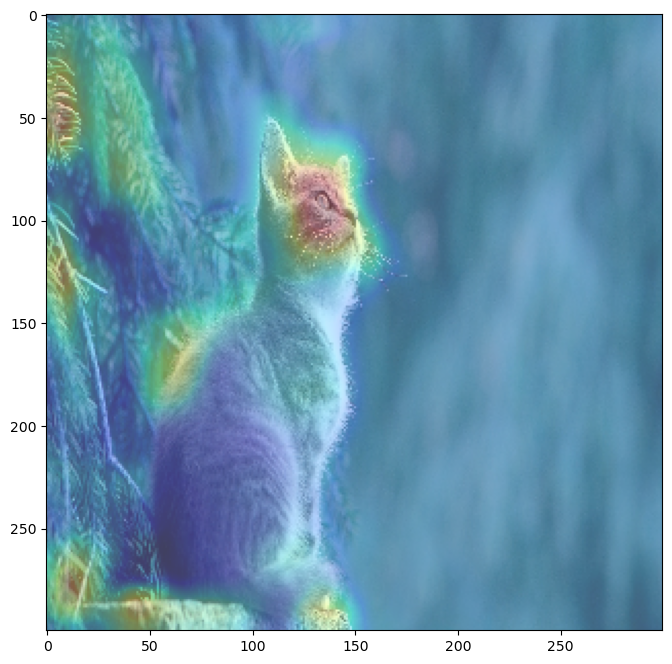

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
sigmoid output: [[0.64424676]]
prediction: dog


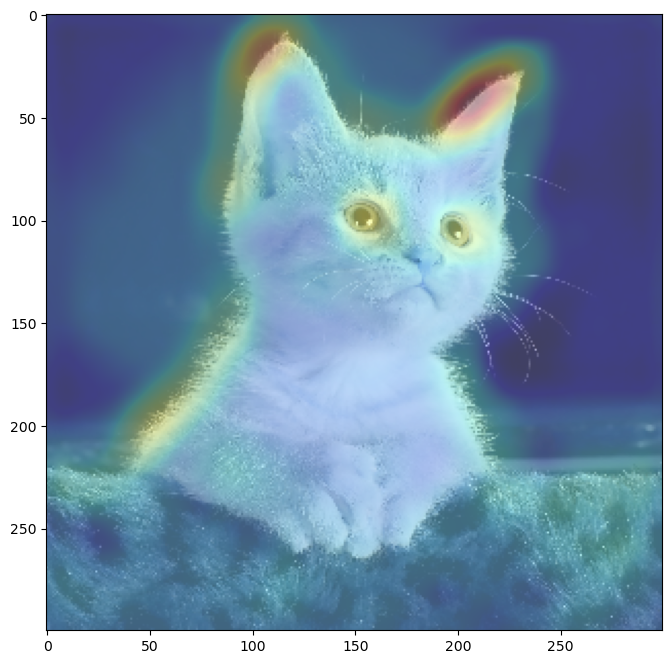

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
sigmoid output: [[0.6192338]]
prediction: dog


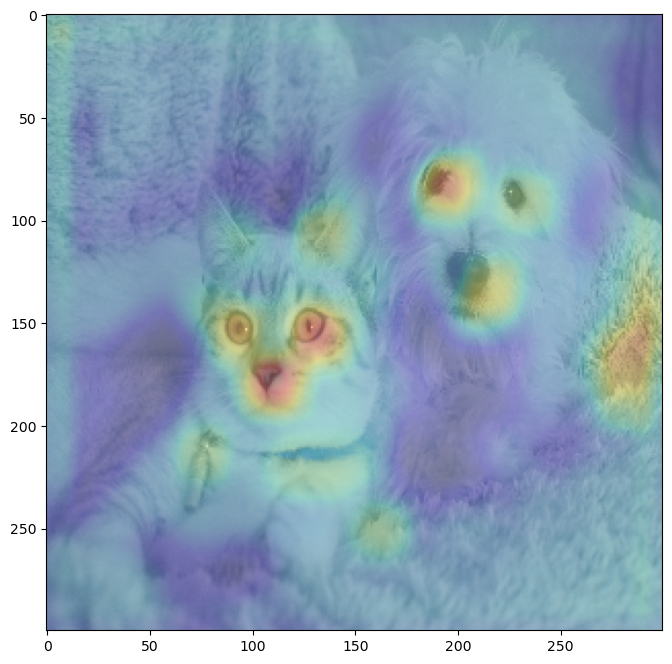

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
sigmoid output: [[0.6597176]]
prediction: dog


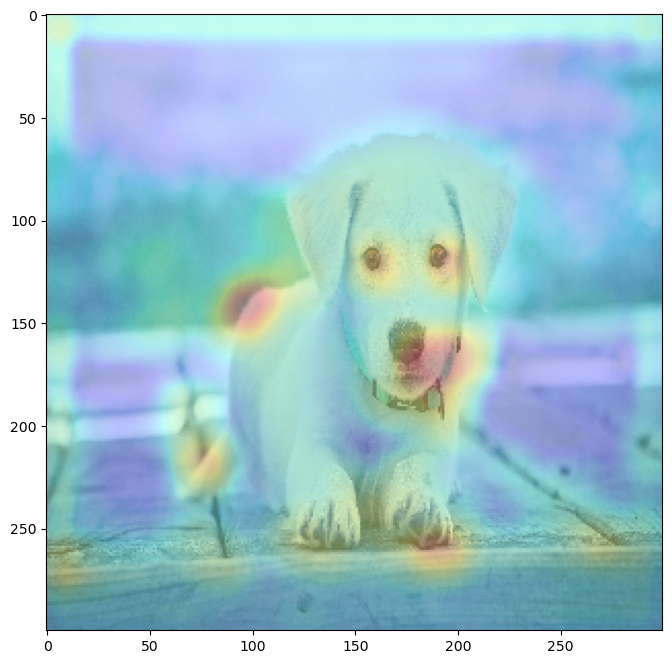

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
sigmoid output: [[0.8066623]]
prediction: dog


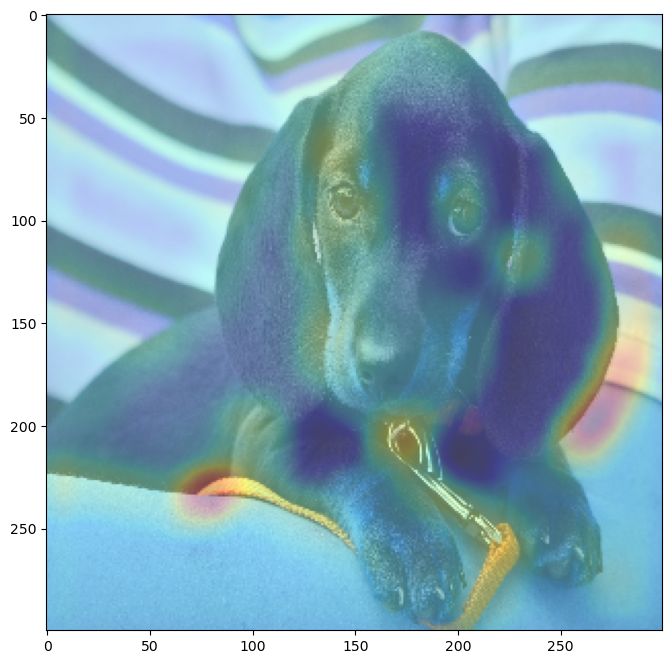

In [18]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)

  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')

Let's also try it with some of the test images before we make some observations.

ground truth: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
sigmoid output: [[0.59313685]]
prediction: dog


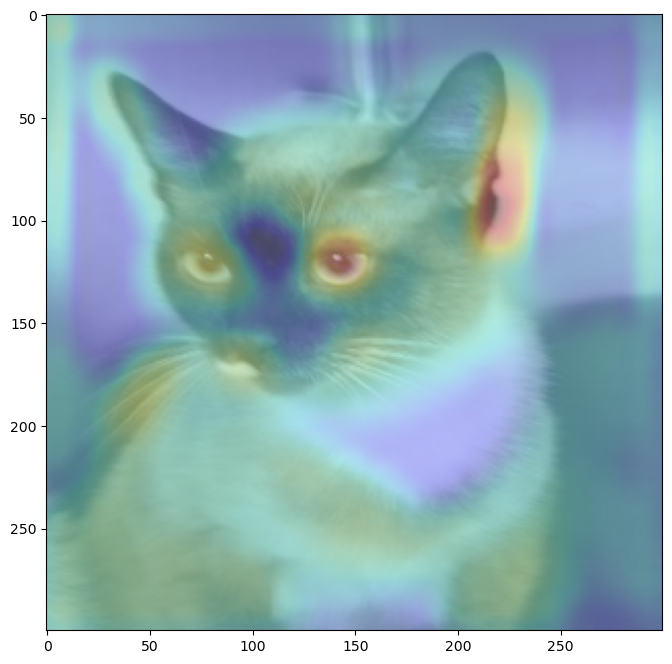

ground truth: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
sigmoid output: [[0.7514643]]
prediction: dog


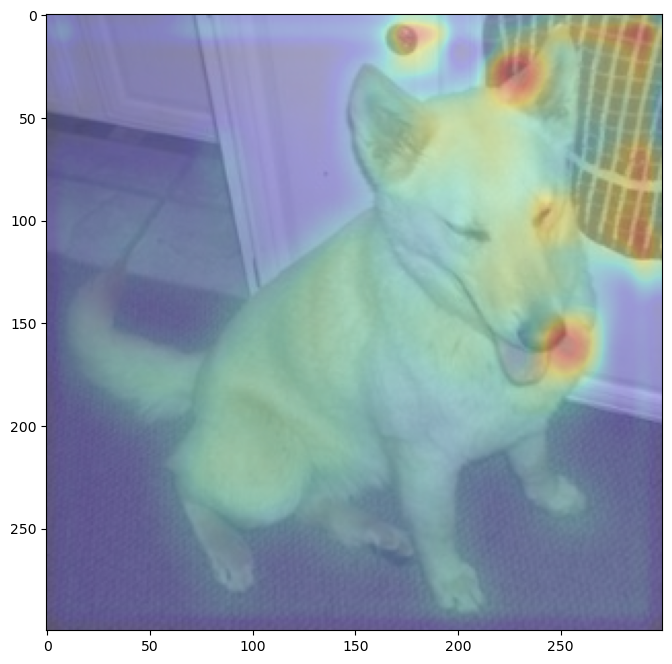

ground truth: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
sigmoid output: [[0.739887]]
prediction: dog


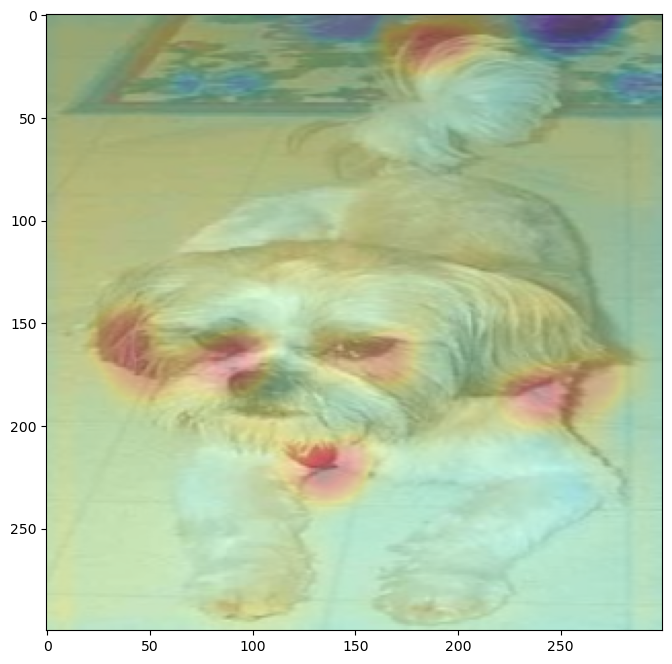

ground truth: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
sigmoid output: [[0.7195538]]
prediction: dog


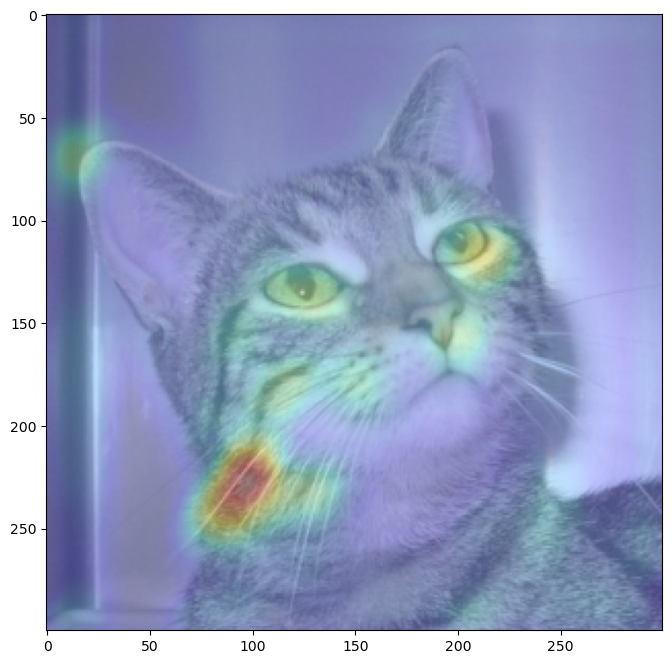

ground truth: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
sigmoid output: [[0.65999544]]
prediction: dog


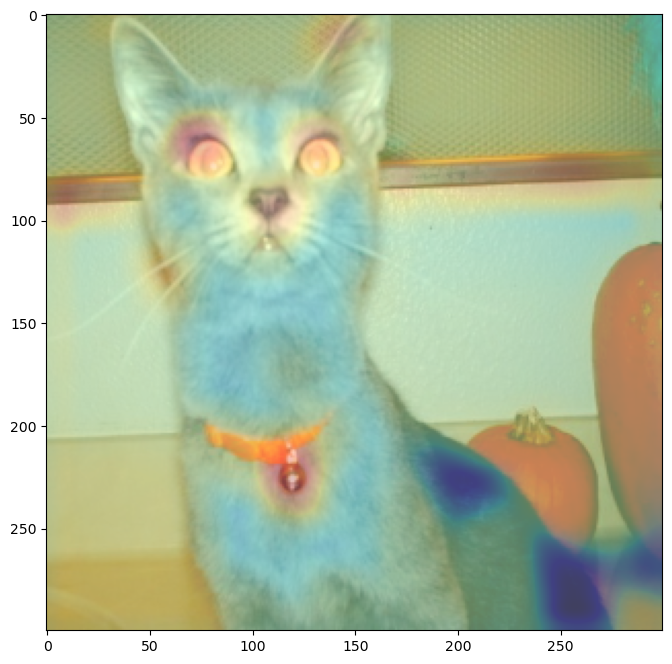

2025-06-06 10:08:12.693662: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
# preprocess the test images
augmented_test_data = test_data.map(augment_images)
test_batches = augmented_test_data.batch(1)


for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img, features, results)

If your training reached 80% accuracy, you may notice from the images above that the presence of eyes and nose play a big part in determining a dog, while whiskers and a colar mostly point to a cat. Some can be misclassified based on the presence or absence of these features. This tells us that the model is not yet performing optimally and we need to tweak our process (e.g. add more data, train longer, use a different model, etc).